In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import bootstrap, kruskal

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
exp = "17"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [4]:
data = pd.read_feather(data_path)

In [5]:
target1 = "left"
target1_label = "Left"
target2 = "right"
target2_label = "Right"

In [6]:
target1_results_path = os.path.join(results_path, f"exp{exp}_scores_{target1}.2.txt")
target2_results_path = os.path.join(results_path, f"exp{exp}_scores_{target2}.2.txt")

In [7]:
# Get severities for group1-targeting comments
target1_results = pd.read_csv(target1_results_path, delimiter='\t', skiprows=1)
target1_annotators = target1_results['Judges']
target1_severities = target1_results['Measure']
# Get severities for group2-targeting comments
target2_results = pd.read_csv(target2_results_path, delimiter='\t', skiprows=1)
target2_annotators = target2_results['Judges']
target2_severities = target2_results['Measure']

In [8]:
# Get annotators that looked at both group-targeting comments
common_annotators = target1_annotators[target1_annotators.isin(target2_annotators)].values
target1_common = target1_results[target1_results['Judges'].isin(common_annotators)]
target2_common = target2_results[target2_results['Judges'].isin(common_annotators)]
print(f'Common annotators: {common_annotators.size}')

Common annotators: 2410


In [9]:
# Race: black vs. white
bla_diffs, whi_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    ['annotator_race_black', 'annotator_race_white'])
# Gender: women vs. men
wom_diffs, men_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    ['annotator_gender_men', 'annotator_gender_women'])
# Education: high-school vs. college vs. graduate
hs_diffs, col_diffs, grad_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_education_some_high_school', 'annotator_education_high_school_grad'],
     ['annotator_education_some_college', 'annotator_education_college_grad_aa', 'annotator_education_college_grad_ba'],
     ['annotator_education_professional_degree', 'annotator_education_masters', 'annotator_education_phd']])
# Income: low-, middle-, and high-income
li_diffs, mi_diffs, hi_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_income_<10k', 'annotator_income_10k-50k'],
     ['annotator_income_50k-100k', 'annotator_income_100k-200k'],
     ['annotator_income_>200k']])
# Religion: Christian vs. atheists/non-religious
chr_diffs, ath_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    ['annotator_religion_christian',
     ['annotator_religion_atheist', 'annotator_religion_nothing']])
# Sexual Orientation: Straight vs. Queer
str_diffs, que_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    ['annotator_sexuality_straight',
     ['annotator_sexuality_bisexual', 'annotator_sexuality_gay', 'annotator_sexuality_other']])
# Political ideology: liberal vs. independent vs. conservative
cons_diffs, ind_diffs, lib_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_ideology_extremeley_conservative', 'annotator_ideology_conservative', 'annotator_ideology_slightly_conservative'],
     ['annotator_ideology_neutral'],
     ['annotator_ideology_extremeley_liberal', 'annotator_ideology_liberal', 'annotator_ideology_slightly_liberal']])

In [10]:
print(f"Black / White: {kruskal(bla_diffs, whi_diffs).pvalue:0.5f}")
print(f"Men / Women: {kruskal(wom_diffs, men_diffs).pvalue:0.5f}")
print(f"High School / College / Graduate: {kruskal(hs_diffs, col_diffs, grad_diffs).pvalue:0.5f}")
print(f"Low-income / Middle-income / High-income: {kruskal(li_diffs, mi_diffs, hi_diffs).pvalue:0.5f}")
print(f"Christian / Non-religious: {kruskal(chr_diffs, ath_diffs).pvalue:0.5f}")
print(f"Straight / Queer: {kruskal(str_diffs, que_diffs).pvalue:0.5f}")
print(f"Liberal / Independent / Conservative: {kruskal(cons_diffs, ind_diffs, lib_diffs).pvalue:0.5f}")

Black / White: 0.16188
Men / Women: 0.00074
High School / College / Graduate: 0.23683
Low-income / Middle-income / High-income: 0.84230
Christian / Non-religious: 0.00009
Straight / Queer: 0.00004
Liberal / Independent / Conservative: 0.00000


In [11]:
diffs = [
    np.exp(-bla_diffs), np.exp(-whi_diffs),
    np.exp(-wom_diffs), np.exp(-men_diffs),
    np.exp(-hs_diffs), np.exp(-col_diffs), np.exp(-grad_diffs),
    np.exp(-li_diffs), np.exp(-mi_diffs), np.exp(-hi_diffs),
    np.exp(-chr_diffs), np.exp(-ath_diffs),
    np.exp(-str_diffs), np.exp(-que_diffs),
    np.exp(-lib_diffs), np.exp(-ind_diffs), np.exp(-cons_diffs)]
errors = [bootstrap([diff], np.median, method='basic').standard_error for diff in diffs]

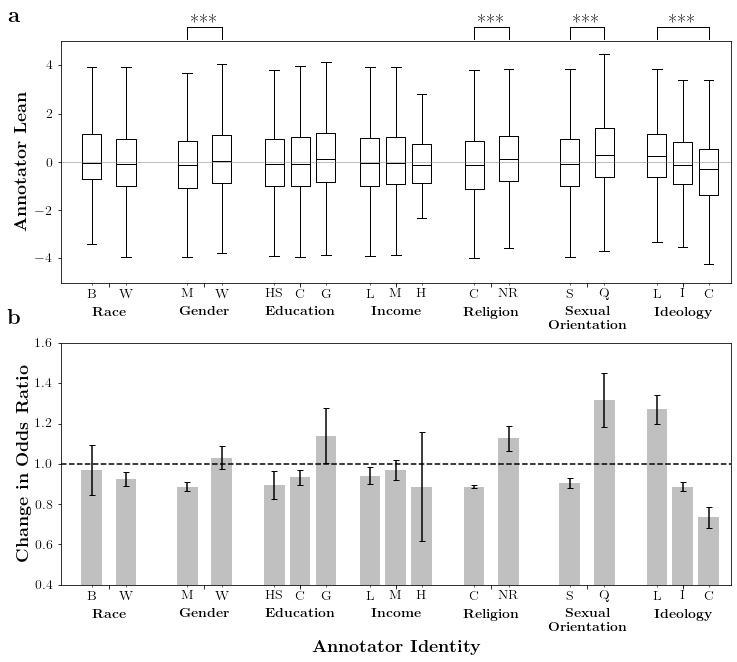

In [13]:
"""
Figure 3
"""
width = 0.2
spacing = 0.18
axis_label_size = 18
axis_tick_label_size = 14
subplot_label_size = 22
error_capsize = 3

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.25)

xticks_by_group = [
    [-spacing, spacing],
    [1 - spacing, 1 + spacing],
    [2 - 1.5 * spacing, 2.0001, 2. + 1.5 * spacing],
    [3 - 1.5 * spacing, 3.0001, 3 + 1.5 * spacing],
    [4 - spacing, 4 + spacing],
    [5 - spacing, 5 + spacing],
    [6 - 1.5 * spacing, 6.0001, 6 + 1.5 * spacing]
]
all_xticks = np.concatenate(xticks_by_group)

diffs_by_group = [
    [-bla_diffs, -whi_diffs],
    [-wom_diffs, -men_diffs],
    [-hs_diffs, -col_diffs, -grad_diffs],
    [-li_diffs, -mi_diffs, -hi_diffs],
    [-chr_diffs, -ath_diffs],
    [-str_diffs, -que_diffs],
    [-lib_diffs, -ind_diffs, -cons_diffs]
]

"""
Figure 3a: Annotator Lean
"""
# Race
for diff, xticks in zip(diffs_by_group, xticks_by_group):
    axes[0].boxplot(
        x=diff,
        positions=xticks,
        showfliers=False,
        widths=width,
        medianprops={'color': 'black', 'lw': 1},
        boxprops={'lw': 1})
# Gender
mplego.labels.add_significance_label(
    ax=axes[0],
    bounds=[1 - spacing, 1 + spacing],
    which='top',
    label='***')
# Religion
mplego.labels.add_significance_label(
    ax=axes[0],
    bounds=[4 - spacing, 4 + spacing],
    which='top',
    label='***')
# Sexuality
mplego.labels.add_significance_label(
    ax=axes[0],
    bounds=[5 - spacing, 5 + spacing],
    which='top',
    label='***')
# Political ideology
mplego.labels.add_significance_label(
    axes[0],
    bounds=[6 - 1.5 * spacing, 6 + 1.5 * spacing],
    which='top',
    label='***')
# Origin line
axes[0].axhline(0, linestyle='-', color='gray', lw=0.5)
axes[0].set_ylim([-5, 5])
axes[0].set_ylabel(r'\textbf{Annotator Lean}', fontsize=axis_label_size)

"""
Figure 3b: Odds ratio
"""
axes[1].bar(
    x=all_xticks,
    height=[np.median(diff) for diff in diffs],
    width=1.2 * spacing,
    yerr=errors,
    color='silver',
    error_kw={'capsize': error_capsize})

axes[1].axhline(1, color='black', linestyle='--')
axes[1].set_xlabel(r'\textbf{Annotator Identity}', fontsize=axis_label_size)
axes[1].set_ylabel(r'\textbf{Change in Odds Ratio}', fontsize=axis_label_size)
axes[1].set_ylim([0.4, 1.6])

xticks = mplego.labels.bold_text(['Race', 'Gender', 'Education', 'Income', 'Religion', 'Sexual Ori.', 'Ideology'])
xticks[-2] = r'\textbf{Sexual}''\n'r'\textbf{Orientation}'

for ax in axes:
    ax.set_xticks(all_xticks, minor=True)
    ax.set_xticklabels(['B', 'W', 'M', 'W', 'HS', 'C', 'G', 'L', 'M', 'H', 'C', 'NR', 'S', 'Q', 'L', 'I', 'C'], minor=True)
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(xticks)
    ax.tick_params(labelsize=axis_tick_label_size, which='major', pad=20)
    ax.tick_params(labelsize=axis_tick_label_size, which='minor')
    ax.tick_params(axis='y', pad=5)
    ax.set_xlim([-0.5, 6.5])

mplego.labels.apply_subplot_labels(axes, bold=True, size=subplot_label_size, x=-0.07, y=1.1)
plt.savefig('figureA2.pdf', bbox_inches='tight')